# M1. Simulación de Robot Aspirador

Alfonso Pineda Cedillo | A01660394

---

El objetivo de la actividad es realizar una simulación de un sistema multiagente basado en un robot aspirador, para este primer ejercicio, el movimiento de cada uno de los agentes es completamente aleatorio. Para dar solución a la presente actividad, es neceserario crear un ambiente donde se encontrará el robot, dicho ambiente estará conformado por celdas, las cuales pueden tener un valor booleano de limpio o sucuio. Finalmente, se busca hacer un análisis de las estadísitcas generales con la información generada por los agentes. 

Una vez considerado lo anterior, es necesario establecer una serie de parámetros iniciales:

*   La habitación (ambiente) tiene un tamaño de M * N celdas.
*   Contará con un número n de agentes (robots).
*   Porcentaje de celdas inicialmente sucias.
*   Tiempo máximo de ejecución.

Asimismo, contamos con consideraciones iniciales para la simulación:

*   De acuerdo con el porcentaje previamente mencionado, se inicializarán las celdas sucias de manera aleatoria. 
*   Los agentes (robots) se inicializarán en la celda [1,1].
*   Para cada paso de tiempo, los agentes deverán considerar lo siguiente:
    *   Si la celda está sucia, entonces aspira.
     *   Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
*   Se ejecuta el tiempo máximo establecido.

## Ambiente

De acuerdo con la información que tenemos disponible del problema, podemos inferir que contamos con un ambiente parcialmente observable. A pesar de que nosotros como usuarios tenemos visibilidad de todo el tablero, los agentes no cuentan con dicha capacidad, cada robot únicamente puede ver el estado de la celda en la que se encuentra ubicado; en otras palabras, los agentes no cuentan con información del resto de las celdas ni de su comportamiento a lo largo de la simulación. 

Asimismo, podemos considerar que para este caso particular, contamos con un ambiente estocástico, lo que significa que tiene un comportamiento no determinista; es decir, debido a que el comportamiento de los agentes es completamente al azar, se convierte en un proceso cuyo resultado no es predecible. Es por eso que a lo largo de la actividad, realizaremos diversas iteraciones de la simulación para poder obtener estadísticas generales de la misma.

Por otra parte, el ambiente se clasificaría de igual forma como episódico, debido a que existe una división de episodios independientes entre sí; el primero consiste en la percepción del agente (el análisis del estado de la celda en la que se encuentra), el segundo en la acción que se llevará a cabo (aspirar o moverse).

Por último, nuestro ambiente también se clasificaría como dinámico, esto debido a que el estado de las celdas puede cambiar a lo largo de la simulación, es decir, las celdas pueden pasar de estar sucias a limpias; este proceso de cambio puede llevarse a cabo incluso al momento en que un robot esté deliberando su próximo movimiento. Debido a lo anterior, es necesario hacer énfasis en que el sistema es multiagente, de manera simultánea existen diversos agentes que interactúan con el ambiente.

## Agentes

Los agentes son los encargados de realizar las acciones dentro del ambiente, en este caso, los agentes son los robots aspiradores. Cada uno de estos robots tiene la capacidad de moverse y aspirar, además de que cada uno de ellos tiene la capacidad de percibir el estado de la celda en la que se encuentra ubicado. Debido a lo anterior, podemos considerar a los agentes como reactivos simples, puesto que sus decisiones se basan únicamente en la información que tienen disponible en el momento (precepto actual) y no en un historial de preceptos; como lo hemos visto anteriormente, el comportamiento de los agentes se basa en verificar si la celda en la que se encuentra esta limpia o sucia, si está limpia, entonces elige una dirección aleatoria para moverse, si está sucia, entonces aspira.

De acuerdo con la información previamente mencionada, podemos establecer que el precepto inicial de cada agente es su posición inicial; así que para cada paso posterior, el precepto únicamente será el estado de la celda en la que se encuentra ubicado, debido a que es el único criterio que necesita para tomar una decisión. 

Por cuestiones de aplicación (para poder agregar una cantidad diferente de suciedad dependiendo de los parámetros iniciales del sistema), establecimos a la suciedad (trash) como un agente más, el cual tiene como precepto inicial estar sucio. 

## Simulación
Primero que nada, es necesario importar las librerías que son necesarias para la realización y análisis de la simulación. Para este ejercicio, haremos uso de la librería mesa como librería principal para la simulación de nuestro modelo basado en agentes, así como de librerías auxiliares.

In [2]:
import mesa
import random
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Contador de movimientos
movesCounter = 0

Definimos al agente que representa la suciedad (trash), el cual, al inicializarlo tiene como precepto su condición inicial previamente descrita, la cual es que debe estar sucio (Suciedad -> 1).

In [3]:
class Trash(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = 1

    def step(self):
        pass


Definimos al agente que representa a nuestro robor aspirador (robot)

In [13]:
class Robot(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = "Cleaning"

    def move(self):
        # Definimos la lista de posiciones posibles
        nextStep = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)

        # De forma aleatroia seleccionamos una posición de la lista
        new_position = self.random.choice(nextStep)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        self.move()

        # Obtiene la lista de los agentes en la posición actual
        cellmates = self.model.grid.get_cell_list_contents([self.pos])

        # En cada paso, si la celda está sucia, se limpia; si la cella está limpia, se mueve. 
        if any(isinstance(agent, Trash) for agent in cellmates):
            trash = next(
                agent for agent in cellmates if isinstance(agent, Trash))

            self.state = "Cleaning"
            self.model.grid.remove_agent(trash)

        else:
            self.state = "Moving"

        # # Imprimir el estado del agente de tipo Vacuum
        # print("Vacuum", self.unique_id, ":", self.state)

{"type":"get_step","step":69}
Dirty cells: 92


{"type":"get_step","step":70}
Dirty cells: 92
{"type":"get_step","step":71}
Dirty cells: 92
{"type":"get_step","step":72}
Dirty cells: 92
{"type":"get_step","step":73}
Dirty cells: 92
{"type":"get_step","step":74}
Dirty cells: 92
{"type":"get_step","step":75}
Dirty cells: 92
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
Dirty cells: 96
{"type":"get_step","step":2}
Dirty cells: 94
{"type":"get_step","step":3}
Dirty cells: 92
{"type":"get_step","step":4}
Dirty cells: 91
{"type":"get_step","step":5}
Dirty cells: 87
{"type":"get_step","step":6}
Dirty cells: 85
{"type":"get_step","step":7}
Dirty cells: 82
{"type":"get_step","step":8}
Dirty cells: 81
{"type":"get_step","step":9}
Dirty cells: 79
{"type":"get_step","step":10}
Dirty cells: 77
{"type":"get_step","step":11}
Dirty cells: 76
{"type":"get_step","step":12}
Dirty cells: 73
{"type":"get_step","step":13}
Dirty cells: 71
{"type":"get_step","step":14}
Dirty cells: 70
{"type":"get_step","step":15}
Dirty cells: 69
{"type":"ge

Declaramos la clase para nuestro modelo

In [27]:
class Simulation(mesa.Model):
    steps = 0
    def __init__(self, M, N, n_agents, dirtyCells, max_steps=100):
        self.num_agents = n_agents
        self.grid = mesa.space.MultiGrid(M, N, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.max_steps = max_steps
        self.running = True
        self.steps = 0

        # Creamos los robots aspiradores (agentes)
        for i in range(self.num_agents):
            r = Robot(i, self)
            self.schedule.add(r)

            self.grid.place_agent(r, (1, 1)) # El agente se inicializa en la posición (1, 1)

        # Creamos al agente que representa la suciedad
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            if self.random.random() < dirtyCells:
                trash = Trash((x, y), self)
                self.grid.place_agent(trash, (x, y))

    def step(self):
        # Si se alcanza el límite de pasos, se detiene la simulación
        self.steps += 1
        steps += 1
        if self.schedule.steps >= self.max_steps:
            self.running = False

        # Si aún no se alcanza el límite de pasos, se ejecuta el paso de la simulación a menos que no haya celdas sucias
        elif self.schedule.steps < self.max_steps:
            if self.dirtyCells() == 0:
                self.running = False

            else:
                self.schedule.step()

        # Imprime el número de celdas Dirty
        print("Dirty cells:", self.dirtyCells())

    def run_model(self):
        # Mientras la simulación se esté ejecutando
        while self.running:
            # Ejecuta el paso de la simulación
            self.step()

    # Fucnión que nos permite obtener los movimeintos totales de los agentes
    def totalMoves(self):
        movesCounter = 0
        for agent in self.schedule.agents:
            movesCounter += agent.moves
        return movesCounter

    # Función que nos permite obtener el número de celdas limpias
    def cleanCells(self):
        cleanCellsCounter = 0
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            if not any(isinstance(agent, Trash) for agent in cell_content):
                cleanCellsCounter += 1
        return cleanCellsCounter

    # Función que nos permite obtener el porcentaje de celdas limpias
    def cleanCellsP(self):
        return self.cleanCells() / (self.grid.width * self.grid.height) * 100

    # Función que nos permite obtener el número de celdas sucias
    def dirtyCells(self):
        dirtyCellsCounter = 0
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            if any(isinstance(agent, Trash) for agent in cell_content):
                dirtyCellsCounter += 1
        return dirtyCellsCounter

    # Función que nos permite obtener el porcentaje de celdas sucias
    def dirtyCellsP(self):
        # Calcula el porcentaje de celdas Dirty
        return self.dirtyCells() / (self.grid.width * self.grid.height) * 100

In [28]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                "Filled": "true",
                "Layer": 0,
                "Color": "red",
                "r": 0.5}

    if agent.state == 1:
        portrayal["Color"] = "black"
        portrayal["r"] = 0.2
    elif agent.state == "Cleaning":
        portrayal["Color"] = "blue"
    else:
        portrayal["Color"] = "blue"
    return portrayal

grid = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = mesa.visualization.ModularServer(
    Simulation, [grid], "Habitación", {"M": 10, "N": 10, "n_agents": 5, "dirtyCells": 3 }
    )

server.port = 8003 # The default
server.launch()

Interface starting at http://127.0.0.1:8003


OSError: [Errno 48] Address already in use

<bound method Simulation.dirtyCells of <__main__.Simulation object at 0x12f574340>>


NameError: name 'cleanCellsP' is not defined

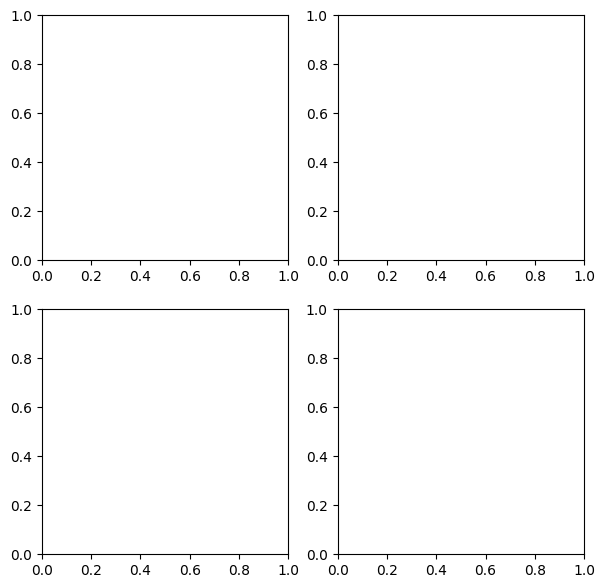

In [29]:
f2, ax2 = plt.subplots(2,2, figsize = (7,7))
print(server.model.dirtyCells)
ax2[0,0].plot(server.model.steps, cleanCellsP, label = "Clean cells")